Grad_CAM on Multi_Label

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms, models
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- Configuration ---
image_folder = ""
output_folder = ""
os.makedirs(output_folder, exist_ok=True)

num_classes = 3
class_names = ['left', 'right', 'forward']
model_choice = "resnet50"  # "mobilenetv2" or "resnet50"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# --- Load Model ---
if model_choice == "mobilenetv2":
    model = models.mobilenet_v2(pretrained=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    checkpoint = ""
    target_layers = [model.features[-1]]
elif model_choice == "resnet50":
    model = models.resnet50(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    checkpoint = ""
    target_layers = [model.layer4[-1]]
else:
    raise ValueError("Choose 'mobilenetv2' or 'resnet50'")

model.load_state_dict(torch.load(checkpoint, map_location=device), strict=False)
model.to(device)
model.eval()

# --- Preprocessing ---
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])   # for grayscale input
])

# --- GradCAM ---
cam = GradCAM(model=model, target_layers=target_layers)

# --- Process images ---
for fname in os.listdir(image_folder):
    if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    img_path = os.path.join(image_folder, fname)

    # Load grayscale image
    img = Image.open(img_path).convert('L')
    img_resized = img.resize((224, 224))
    rgb_img = np.stack([np.array(img_resized)/255.0]*3, axis=-1)

    input_tensor = preprocess(img).unsqueeze(0)  # [1, 1, H, W]
    input_tensor = input_tensor.repeat(1, 3, 1, 1).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.sigmoid(outputs).cpu().numpy()[0]

    # Sort classes by probability (descending)
    sorted_indices = np.argsort(probs)[::-1]  # [top, mid, low]
    sorted_probs = probs[sorted_indices]
    sorted_classnames = [class_names[i] for i in sorted_indices]

    print(f"\n{fname} → Class probabilities:")
    for cname, p in zip(sorted_classnames, sorted_probs):
        print(f"  {cname}: {p:.4f}")

    # Generate CAMs for top, mid, and low
    for rank, (cls_idx, cls_name) in enumerate(zip(sorted_indices, sorted_classnames)):
        if rank == 0:
            rank_label = "TOP"
        elif rank == 1:
            rank_label = "MID"
        else:
            rank_label = "LOW"

        # GradCAM for this class
        targets = [ClassifierOutputTarget(int(cls_idx))]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        vis_bgr = cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR)

        # Save result
        save_name = f"{cls_name}_{rank_label}_{fname}"
        save_path = os.path.join(output_folder, save_name)
        cv2.imwrite(save_path, vis_bgr)

        print(f"Saved: {save_path}")



four_way_intersection_004243.jpg → Class probabilities:
  right: 1.0000
  left: 1.0000
  forward: 1.0000
Saved: /home/intellisense08/Yehan/project_dir/Real_World_data/grad_cam/output_data_keells_lib_aug_left_right/Rn/syn/all_labels/1_1_1/4/right_TOP_four_way_intersection_004243.jpg
Saved: /home/intellisense08/Yehan/project_dir/Real_World_data/grad_cam/output_data_keells_lib_aug_left_right/Rn/syn/all_labels/1_1_1/4/left_MID_four_way_intersection_004243.jpg
Saved: /home/intellisense08/Yehan/project_dir/Real_World_data/grad_cam/output_data_keells_lib_aug_left_right/Rn/syn/all_labels/1_1_1/4/forward_LOW_four_way_intersection_004243.jpg


Grad_CAM Composition

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms, models

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- Configuration ---
image_folder = ""
output_folder = ""
os.makedirs(output_folder, exist_ok=True)

num_classes = 3
class_names = ['left', 'right', 'forward']
model_choice = "resnet50"  # or "resnet50"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# --- Load Model ---
if model_choice == "mobilenetv2":
    model = models.mobilenet_v2(pretrained=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    checkpoint = ""
    target_layers = [model.features[-1]]
elif model_choice == "resnet50":
    model = models.resnet50(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    checkpoint = ""
    target_layers = [model.layer4[-1]]
else:
    raise ValueError("Choose 'mobilenetv2' or 'resnet50'")

model.load_state_dict(torch.load(checkpoint, map_location=device), strict=False)
model.to(device)
model.eval()

# --- Preprocessing ---
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# --- GradCAM ---
cam = GradCAM(model=model, target_layers=target_layers)

# --- Process images ---
for fname in os.listdir(image_folder):
    if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    img_path = os.path.join(image_folder, fname)

    # Load grayscale image
    img = Image.open(img_path).convert('L')
    img_resized = img.resize((224, 224))
    rgb_img = np.stack([np.array(img_resized)/255.0]*3, axis=-1)

    # Model input
    input_tensor = preprocess(img).unsqueeze(0)
    input_tensor = input_tensor.repeat(1,3,1,1).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.sigmoid(outputs).cpu().numpy()[0]
        print("Probabilities", probs)

    # Sort classes by probability
    sorted_indices = np.argsort(probs)[::-1]  # top -> mid -> low
    sorted_classnames = [class_names[i] for i in sorted_indices]

    combined_heatmap = np.zeros((224, 224), dtype=np.float32)  # grayscale combined

    for rank, cls_idx in enumerate(sorted_indices):
        if rank == 0:
            rank_label = "TOP"
        elif rank == 1:
            rank_label = "MID"
        else:
            rank_label = "LOW"

        # Generate Grad-CAM
        targets = [ClassifierOutputTarget(int(cls_idx))]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
        grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)

        # Overlay on original image
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        vis_bgr = cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR)

        # Save individual class CAM
        save_path = os.path.join(output_folder, f"{sorted_classnames[rank]}_{rank_label}_{fname}")
        cv2.imwrite(save_path, vis_bgr)
        print(f"Saved: {save_path}")

        # Add to combined heatmap (grayscale)
        combined_heatmap += grayscale_cam

    # Normalize combined heatmap
    #combined_heatmap = np.clip(combined_heatmap, 0, 1)
    combined_overlay = show_cam_on_image(rgb_img, combined_heatmap, use_rgb=True)
    combined_overlay_bgr = cv2.cvtColor(combined_overlay, cv2.COLOR_RGB2BGR)

    # Save combined overlay
    combined_save_path = os.path.join(output_folder, f"COMBINED_{fname}")
    cv2.imwrite(combined_save_path, combined_overlay_bgr)
    print(f"Saved combined overlay: {combined_save_path}")


/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/intellisense08/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Probabilities [9.9999595e-01 9.9999595e-01 6.6427874e-06]
Saved: /home/intellisense08/Yehan/project_dir/Real_World_data/grad_cam/output_data_keells_lib_aug_left_right/Rn/syn/all_labels/1_1_0/4/right_TOP_data5_t_intersection_000221.jpg
Saved: /home/intellisense08/Yehan/project_dir/Real_World_data/grad_cam/output_data_keells_lib_aug_left_right/Rn/syn/all_labels/1_1_0/4/left_MID_data5_t_intersection_000221.jpg
Saved: /home/intellisense08/Yehan/project_dir/Real_World_data/grad_cam/output_data_keells_lib_aug_left_right/Rn/syn/all_labels/1_1_0/4/forward_LOW_data5_t_intersection_000221.jpg
Saved combined overlay: /home/intellisense08/Yehan/project_dir/Real_World_data/grad_cam/output_data_keells_lib_aug_left_right/Rn/syn/all_labels/1_1_0/4/COMBINED_data5_t_intersection_000221.jpg


grad cam on multi class Mb

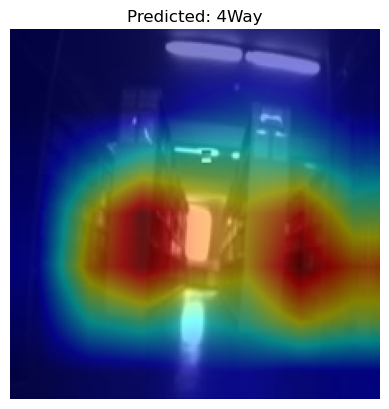

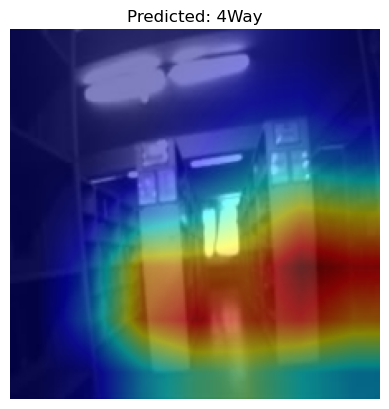

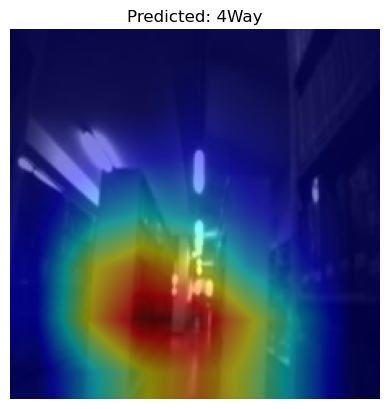

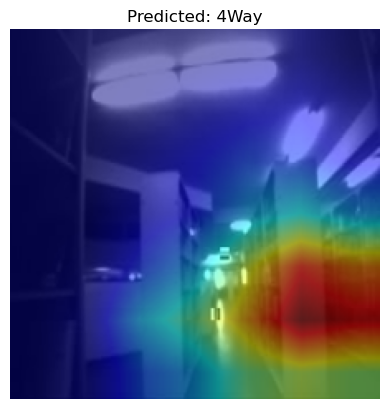

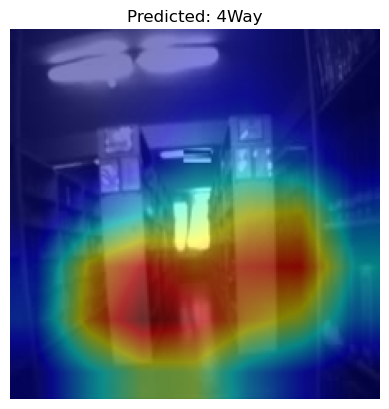

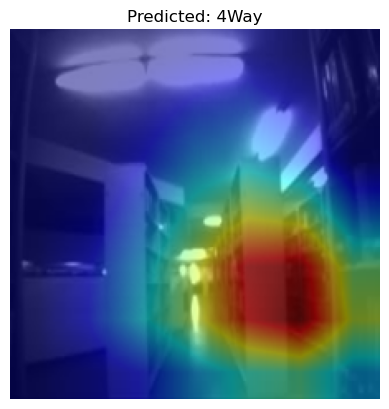

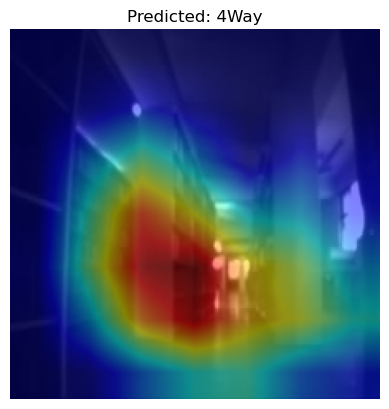

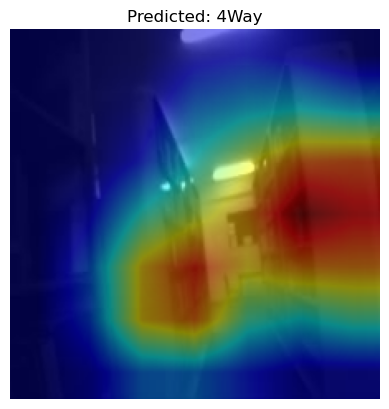

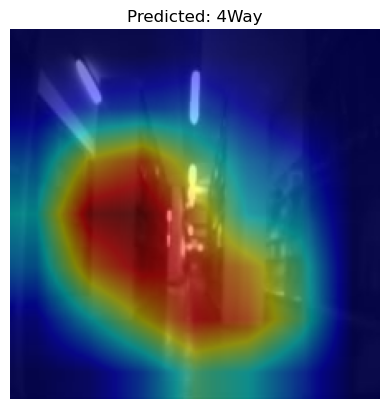

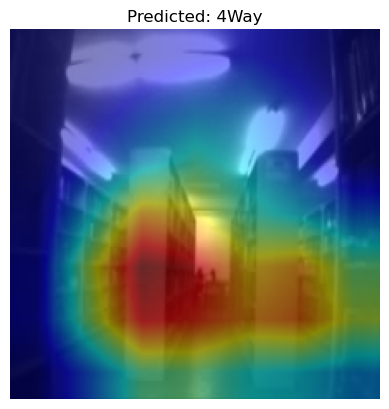

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms, models
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- Configuration ---
image_folder = ""
num_classes = 5
class_names = ['4Way', 'forw', 'left', 'right','t']
model_choice = "resnet50"  # options: "mobilenetv2" or "resnet50"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# --- Load Model ---
if model_choice == "mobilenetv2":
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    checkpoint = ""
    target_layers = model.features[-1]
elif model_choice == "resnet50":
    model = models.resnet50(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    checkpoint = ""
    target_layers = model.layer4[-1]
else:
    raise ValueError("Choose 'mobilenetv2' or 'resnet50'")

model.load_state_dict(torch.load(checkpoint, map_location=device), strict=False)
model.to(device)
model.eval()

# --- Preprocessing ---
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

cam = GradCAM(model=model, target_layers=[target_layers])

# Process images
for fname in os.listdir(image_folder):
    if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    img_path = os.path.join(image_folder, fname)
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize((224, 224))
    rgb_img = np.array(img_resized) / 255.0  # for overlay
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    # Prediction
    outputs = model(input_tensor)
    class_idx = torch.argmax(outputs, dim=1).item()

    # Generate CAM
    targets = [ClassifierOutputTarget(class_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    # Overlay and show
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    plt.title(f"Predicted: {class_names[class_idx]}")
    plt.axis('off')
    plt.show()


grad cam on multi class mb

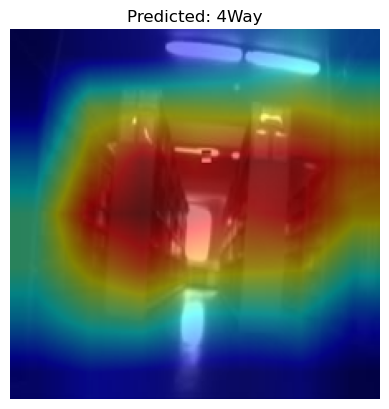

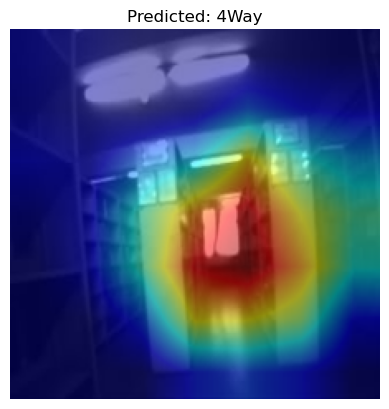

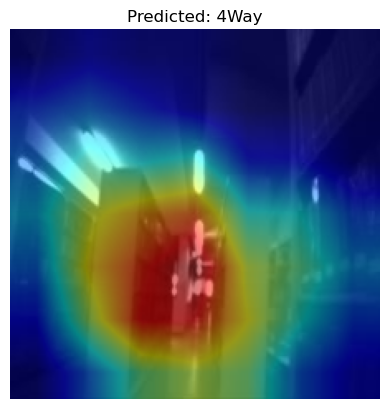

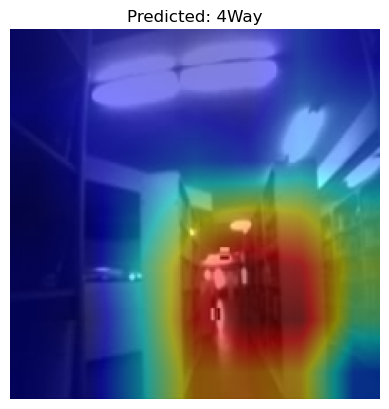

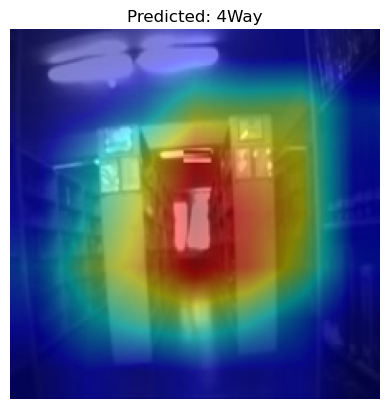

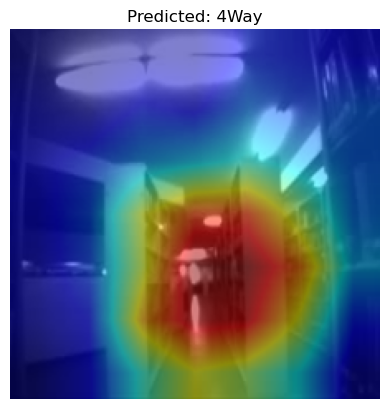

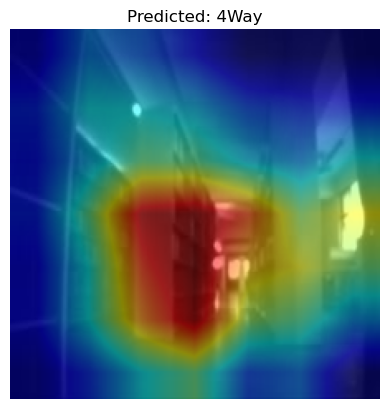

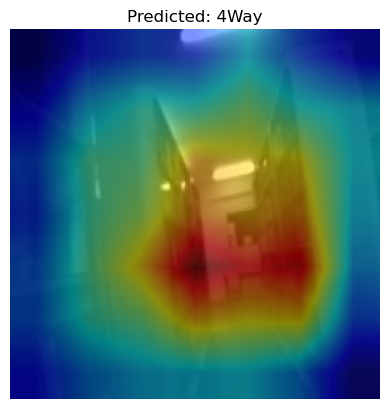

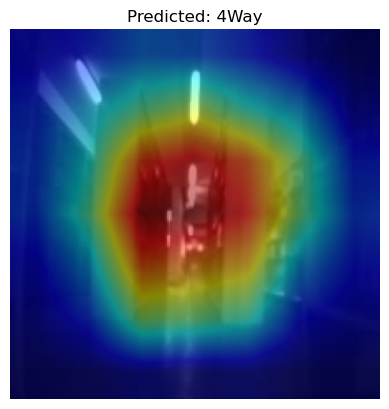

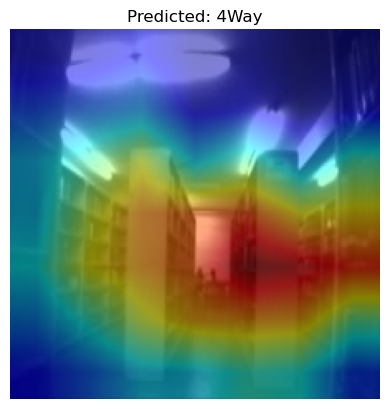

In [ ]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms, models
import matplotlib.pyplot as plt

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# --- Configuration ---
image_folder = ""
num_classes = 5
class_names = ['4Way', 'forw', 'left', 'right','t']
model_choice = "mobilenetv2"  # options: "mobilenetv2" or "resnet50"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# --- Load Model ---
if model_choice == "mobilenetv2":
    model = models.mobilenet_v2(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    checkpoint = ""
    target_layers = model.features[-1]
elif model_choice == "resnet50":
    model = models.resnet50(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    checkpoint = ""
    target_layers = model.layer4[-1]
else:
    raise ValueError("Choose 'mobilenetv2' or 'resnet50'")

model.load_state_dict(torch.load(checkpoint, map_location=device), strict=False)
model.to(device)
model.eval()

# --- Preprocessing ---
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5])
])

cam = GradCAM(model=model, target_layers=[target_layers])

# Process images
for fname in os.listdir(image_folder):
    if not fname.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    img_path = os.path.join(image_folder, fname)
    img = Image.open(img_path).convert('RGB')
    img_resized = img.resize((224, 224))
    rgb_img = np.array(img_resized) / 255.0  # for overlay
    input_tensor = preprocess(img).unsqueeze(0).to(device)

    # Prediction
    outputs = model(input_tensor)
    class_idx = torch.argmax(outputs, dim=1).item()

    # Generate CAM
    targets = [ClassifierOutputTarget(class_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    # Overlay and show
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    plt.title(f"Predicted: {class_names[class_idx]}")
    plt.axis('off')
    plt.show()
